### Importazione librerie

In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

In [2]:
btc_prices = pd.read_csv('Bitcoin (USDT) 2024 timeframe 1m.csv')
btc_prices.set_index('timestamp', inplace=True)
btc_prices.index = pd.to_datetime(btc_prices.index)
btc_prices

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749
2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722
2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511
2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620
2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730
...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956


In [3]:
btc_prices = btc_prices.iloc[:]
btc_prices

,open,high,low,close,volume
timestamp,,,,,
2024-01-01 00:00:00,42284.00,42300.00,42260.01,42300.00,15.059749
2024-01-01 00:01:00,42300.00,42321.99,42299.99,42320.28,4.240722
2024-01-01 00:02:00,42320.28,42335.79,42317.30,42322.57,5.671511
2024-01-01 00:03:00,42322.57,42370.00,42322.57,42366.50,6.801620
2024-01-01 00:04:00,42366.50,42399.68,42366.50,42399.68,6.264730
...,...,...,...,...,...
2024-12-30 23:56:00,92816.59,92878.51,92789.85,92870.74,6.900125
2024-12-30 23:57:00,92870.74,92895.11,92838.44,92844.67,6.369311
2024-12-30 23:58:00,92844.67,92845.68,92797.10,92831.16,6.396956


In [4]:
# Aggiungo una colonna "date" nel caso volessi raggruppare per giorno
btc_prices['date'] = btc_prices.index.date

In [21]:
def decide_action(timestamp, price):
    """
    Funzione che decide se aprire una posizione.
    Per ora restituisce sempre "long".
    """
    return "long" if random.random() > 0.5 else "short"

In [6]:
def simulate_trading(btc_prices, TP, SL, L, p_investment, initial_liquidity, decision_function):
    """
    Simula la strategia di trading sul dataframe btc_prices con i parametri:
      - TP: take profit (es. 0.2 per +20% o -20% per short)
      - SL: stop loss (es. 0.1 per -10% o +10% per short)
      - L: leva (intero tra 1 e 100)
      - p_investment: percentuale della liquidità da investire in ogni trade
    La funzione restituisce un dataframe con:
      - timestamp, price, action, liquidity, btc_held, position_value, total_value_leveraged, real_equity.
      
    La logica per il calcolo di real_equity:
      * Per una posizione long:
          real_equity = free_liquidity + margin * (L * (price/entry_price) - (L-1))
      * Per una posizione short:
          real_equity = free_liquidity + margin * (1 + L * (1 - price/entry_price))
      
    Il valore totale a leva viene calcolato come:
      * Long: free_liquidity + quantity * price
      * Short: free_liquidity + margin * L * (entry_price/price)
    """
    current_liquidity = initial_liquidity  # liquidità corrente
    open_trade = None  # nessuna posizione aperta all'inizio
    output_rows = []
    
    # Iteriamo riga per riga (ogni riga rappresenta 1 minuto)
    for timestamp, row in btc_prices.iterrows():
        price = row['close']
        
        # Se non c'è posizione aperta, decidiamo se aprirne una
        if open_trade is None:
            action_decision = decision_function(timestamp, price)
            if action_decision in ["long", "short"]:
                if action_decision == "long":
                    # Apertura di una posizione long
                    margin = current_liquidity * p_investment        # margine investito
                    free_liquidity = current_liquidity - margin       # liquidità libera
                    notional = margin * L                             # valore nozionale
                    quantity = notional / price                       # BTC acquistati
                    entry_price = price
                    tp_price = entry_price * (1 + TP)
                    sl_price = entry_price * (1 - SL)
                    # Prezzo di liquidazione per long: (100/L - 0.5)% di distanza in ribasso
                    liq_price = entry_price * (1 - 1/L + 0.005)
                    
                    open_trade = {
                        'direction': 'long',
                        'entry_price': entry_price,
                        'margin': margin,
                        'free_liquidity': free_liquidity,
                        'quantity': quantity,
                        'tp_price': tp_price,
                        'sl_price': sl_price,
                        'liq_price': liq_price,
                        'L': L
                    }
                    row_action = "open long"
                    
                    total_value_leveraged = free_liquidity + quantity * price
                    real_equity = free_liquidity + margin * (L * (price/entry_price) - (L-1))
                    
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': row_action,
                        'liquidity': free_liquidity,
                        'btc_held': quantity,
                        'position_value': quantity * price,
                        'total_value_leveraged': total_value_leveraged,
                        'real_equity': real_equity
                    })
                elif action_decision == "short":
                    # Apertura di una posizione short
                    margin = current_liquidity * p_investment        # margine investito
                    free_liquidity = current_liquidity - margin       # liquidità libera
                    notional = margin * L                             # valore nozionale
                    quantity = notional / price                       # quantità di BTC shortati
                    entry_price = price
                    tp_price = entry_price * (1 - TP)  # per short, il TP si attiva con un prezzo più basso
                    sl_price = entry_price * (1 + SL)  # SL si attiva se il prezzo sale
                    # Prezzo di liquidazione per short: entry_price*(1 + 1/L - 0.005)
                    liq_price = entry_price * (1 + 1/L - 0.005)
                    
                    open_trade = {
                        'direction': 'short',
                        'entry_price': entry_price,
                        'margin': margin,
                        'free_liquidity': free_liquidity,
                        'quantity': quantity,
                        'tp_price': tp_price,
                        'sl_price': sl_price,
                        'liq_price': liq_price,
                        'L': L
                    }
                    row_action = "open short"
                    
                    total_value_leveraged = free_liquidity + margin * L * (entry_price/price)
                    real_equity = free_liquidity + margin * (1 + L * (1 - price/entry_price))
                    
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': row_action,
                        'liquidity': free_liquidity,
                        'btc_held': quantity,
                        'position_value': quantity * price,
                        'total_value_leveraged': total_value_leveraged,
                        'real_equity': real_equity
                    })
            else:
                # Nessuna posizione aperta e nessuna decisione di aprirla
                output_rows.append({
                    'timestamp': timestamp,
                    'price': price,
                    'action': "-",
                    'liquidity': current_liquidity,
                    'btc_held': 0,
                    'position_value': 0,
                    'total_value_leveraged': current_liquidity,
                    'real_equity': current_liquidity
                })
        else:
            # Gestione della posizione aperta
            trade = open_trade
            direction = trade['direction']
            entry_price = trade['entry_price']
            quantity = trade['quantity']
            free_liquidity = trade['free_liquidity']
            L = trade['L']
            
            if direction == 'long':
                # Condizione per take profit
                if price >= trade['tp_price']:
                    profit = trade['margin'] * L * (price/entry_price - 1)
                    new_liquidity = free_liquidity + trade['margin'] + profit
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close long (TP)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                # Condizione per stop loss
                elif price <= trade['sl_price']:
                    profit = trade['margin'] * L * (price/entry_price - 1)  # negativo
                    new_liquidity = free_liquidity + trade['margin'] + profit
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close long (SL)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                # Condizione di liquidazione
                elif price <= trade['liq_price']:
                    new_liquidity = free_liquidity
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close long (LIQ)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                else:
                    total_value_leveraged = free_liquidity + quantity * price
                    real_equity = free_liquidity + trade['margin'] * (L * (price/entry_price) - (L-1))
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "long",
                        'liquidity': free_liquidity,
                        'btc_held': quantity,
                        'position_value': quantity * price,
                        'total_value_leveraged': total_value_leveraged,
                        'real_equity': real_equity
                    })
            elif direction == 'short':
                # Per le posizioni short:
                # Condizione per take profit: il prezzo scende fino a tp_price
                if price <= trade['tp_price']:
                    profit = trade['margin'] * L * (1 - price/entry_price)
                    new_liquidity = free_liquidity + trade['margin'] + profit
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close short (TP)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                # Condizione per stop loss: il prezzo sale fino a sl_price
                elif price >= trade['sl_price']:
                    profit = trade['margin'] * L * (1 - price/entry_price)  # negativo
                    new_liquidity = free_liquidity + trade['margin'] + profit
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close short (SL)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                # Condizione di liquidazione: se il prezzo supera il liq_price
                elif price >= trade['liq_price']:
                    new_liquidity = free_liquidity
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "close short (LIQ)",
                        'liquidity': new_liquidity,
                        'btc_held': 0,
                        'position_value': 0,
                        'total_value_leveraged': new_liquidity,
                        'real_equity': new_liquidity
                    })
                    current_liquidity = new_liquidity
                    open_trade = None
                else:
                    total_value_leveraged = free_liquidity + trade['margin'] * L * (entry_price/price)
                    real_equity = free_liquidity + trade['margin'] * (1 + L * (1 - price/entry_price))
                    output_rows.append({
                        'timestamp': timestamp,
                        'price': price,
                        'action': "short",
                        'liquidity': free_liquidity,
                        'btc_held': quantity,
                        'position_value': quantity * price,
                        'total_value_leveraged': total_value_leveraged,
                        'real_equity': real_equity
                    })
                    
    # Se alla fine c'è ancora una posizione aperta, la chiudiamo al prezzo finale
    if open_trade is not None:
        trade = open_trade
        if trade['direction'] == 'long':
            profit = trade['margin'] * L * (price/trade['entry_price'] - 1)
            new_liquidity = trade['free_liquidity'] + trade['margin'] + profit
            output_rows.append({
                'timestamp': timestamp,
                'price': price,
                'action': "close long (end)",
                'liquidity': new_liquidity,
                'btc_held': 0,
                'position_value': 0,
                'total_value_leveraged': new_liquidity,
                'real_equity': new_liquidity
            })
        elif trade['direction'] == 'short':
            profit = trade['margin'] * L * (1 - price/trade['entry_price'])
            new_liquidity = trade['free_liquidity'] + trade['margin'] + profit
            output_rows.append({
                'timestamp': timestamp,
                'price': price,
                'action': "close short (end)",
                'liquidity': new_liquidity,
                'btc_held': 0,
                'position_value': 0,
                'total_value_leveraged': new_liquidity,
                'real_equity': new_liquidity
            })
    
    df_sim = pd.DataFrame(output_rows)
    df_sim.set_index('timestamp', inplace=True)
    return df_sim

In [7]:
df_simulation = simulate_trading(btc_prices, TP=0.3, SL=0.3, L=20, p_investment=0.5, initial_liquidity=1000, decision_function=decide_action)
df_simulation

,price,action,liquidity,btc_held,position_value,total_value_leveraged,real_equity
timestamp,,,,,,,
2024-01-01 00:00:00,42300.00,open long,500.000000,0.236407,10000.000000,10500.000000,1000.000000
2024-01-01 00:01:00,42320.28,long,500.000000,0.236407,10004.794326,10504.794326,1004.794326
2024-01-01 00:02:00,42322.57,long,500.000000,0.236407,10005.335697,10505.335697,1005.335697
2024-01-01 00:03:00,42366.50,long,500.000000,0.236407,10015.721040,10515.721040,1015.721040
2024-01-01 00:04:00,42399.68,long,500.000000,0.236407,10023.565012,10523.565012,1023.565012
...,...,...,...,...,...,...,...
2024-12-30 23:57:00,92844.67,long,260.080931,0.055397,5143.325360,5403.406291,461.868603
2024-12-30 23:58:00,92831.16,long,260.080931,0.055397,5142.576946,5402.657877,461.120188
2024-12-30 23:59:00,92789.06,long,260.080931,0.055397,5140.244728,5400.325659,458.787970


In [8]:
df_simulation['action'].value_counts()

action
long                525568
open long               17
close long (LIQ)        11
close long (TP)          5
close long (end)         1
Name: count, dtype: int64

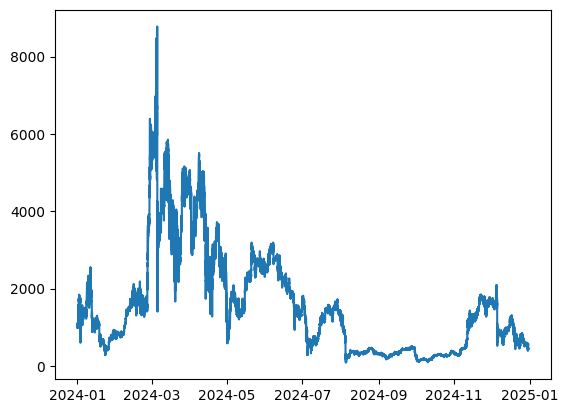

In [9]:
plt.plot(df_simulation.index, df_simulation['real_equity']);

### Grid search

In [99]:
initial_liquidity = 1000

# Definiamo i possibili valori per ciascun parametro
TP_values = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5]             # es. +10%, +20%, +30%
SL_values = [0.001, 0.01, 0.05, 0.1, 0.15, 0.3]           # es. -5%, -10%, -15%
L_values = [1, 10, 30, 50, 100]             # leve differenti
p_investment_values = [0.05, 0.1, 0.2, 0.5, 1]  # percentuali diverse da investire

results = []

# Calcoliamo il numero totale di combinazioni
total_combinations = len(TP_values) * len(SL_values) * len(L_values) * len(p_investment_values)
counter = 0

# Iteriamo su tutte le combinazioni
for TP in TP_values:
    for SL in SL_values:
        for L in L_values:
            for p_inv in p_investment_values:
                counter += 1
                print(f"Testando combinazione {counter}/{total_combinations}: TP={TP}, SL={SL}, L={L}, p_investment={p_inv}")
                df_sim = simulate_trading(btc_prices, TP, SL, L, p_inv, initial_liquidity, decide_action)
                # Utilizziamo il campo real_equity per il calcolo del rendimento reale
                final_equity = df_sim.iloc[-1]['real_equity']
                factor = final_equity / initial_liquidity
                print(f"Combinazione {counter}/{total_combinations} terminata con fattore di rendimento: {factor:.4f}\n")
                
                results.append({
                    'TP': TP,
                    'SL': SL,
                    'L': L,
                    'p_investment': p_inv,
                    'final_equity': final_equity,
                    'factor': factor
                })

# Creiamo un DataFrame con i risultati e lo ordiniamo dal migliore al peggiore
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by='factor', ascending=False)

# Visualizza i risultati della grid search
df_results.reset_index(drop=True, inplace=True)
df_results

Testando combinazione 1/900: TP=0.001, SL=0.001, L=1, p_investment=0.05
Combinazione 1/900 terminata con fattore di rendimento: 1.0036

Testando combinazione 2/900: TP=0.001, SL=0.001, L=1, p_investment=0.1
Combinazione 2/900 terminata con fattore di rendimento: 1.0072

Testando combinazione 3/900: TP=0.001, SL=0.001, L=1, p_investment=0.2
Combinazione 3/900 terminata con fattore di rendimento: 1.0143

Testando combinazione 4/900: TP=0.001, SL=0.001, L=1, p_investment=0.5
Combinazione 4/900 terminata con fattore di rendimento: 1.0346

Testando combinazione 5/900: TP=0.001, SL=0.001, L=1, p_investment=1
Combinazione 5/900 terminata con fattore di rendimento: 1.0653

Testando combinazione 6/900: TP=0.001, SL=0.001, L=10, p_investment=0.05
Combinazione 6/900 terminata con fattore di rendimento: 1.0346

Testando combinazione 7/900: TP=0.001, SL=0.001, L=10, p_investment=0.1
Combinazione 7/900 terminata con fattore di rendimento: 1.0653

Testando combinazione 8/900: TP=0.001, SL=0.001, L=10

,TP,SL,L,p_investment,final_equity,factor
0,0.3,0.30,10,1.0,1152.439716,1.152440
1,0.2,0.10,10,1.0,1152.439716,1.152440
2,0.5,0.10,10,1.0,1152.439716,1.152440
3,0.2,0.15,10,1.0,1152.439716,1.152440
4,0.5,0.30,10,1.0,1152.439716,1.152440
...,...,...,...,...,...,...
895,0.2,0.01,50,1.0,-77.232261,-0.077232
896,0.3,0.01,30,1.0,-90.750859,-0.090751
897,0.2,0.01,30,1.0,-90.750859,-0.090751
898,0.5,0.01,30,1.0,-90.750859,-0.090751


## Ottimizzazione con train, validation e test

In [10]:
def get_data_for_dates(btc_prices, dates):
    """Ritorna i dati che appartengono ai giorni presenti nella lista 'dates'."""
    return btc_prices[btc_prices['date'].isin(dates)].drop(columns=['date'])

In [ ]:
random_state = 8

# Ottieni i giorni unici (convertiti in array per la compatibilità)
unique_days = np.array(sorted(btc_prices['date'].unique()))

# Suddividi i giorni in training (70%) e temp (30%)
train_days, temp_days = train_test_split(unique_days, test_size=0.3, random_state=random_state)

# Suddividi il temp in validation e test (50% ciascuno del 30%)
val_days, test_days = train_test_split(temp_days, test_size=0.5, random_state=random_state)

print("Training days:", train_days.shape)
print("Validation days:", val_days.shape)
print("Test days:", test_days.shape)

Training days: [datetime.date(2024, 2, 3) datetime.date(2024, 3, 31)
 datetime.date(2024, 9, 8) datetime.date(2024, 4, 20)
 datetime.date(2024, 6, 15) datetime.date(2024, 10, 13)
 datetime.date(2024, 8, 30) datetime.date(2024, 12, 10)
 datetime.date(2024, 8, 4) datetime.date(2024, 9, 18)
 datetime.date(2024, 7, 8) datetime.date(2024, 5, 31)
 datetime.date(2024, 12, 3) datetime.date(2024, 8, 1)
 datetime.date(2024, 10, 15) datetime.date(2024, 4, 10)
 datetime.date(2024, 2, 29) datetime.date(2024, 2, 22)
 datetime.date(2024, 6, 11) datetime.date(2024, 3, 29)
 datetime.date(2024, 2, 4) datetime.date(2024, 9, 13)
 datetime.date(2024, 2, 15) datetime.date(2024, 8, 27)
 datetime.date(2024, 4, 4) datetime.date(2024, 9, 11)
 datetime.date(2024, 8, 13) datetime.date(2024, 12, 18)
 datetime.date(2024, 11, 3) datetime.date(2024, 4, 3)
 datetime.date(2024, 10, 10) datetime.date(2024, 4, 23)
 datetime.date(2024, 3, 12) datetime.date(2024, 1, 13)
 datetime.date(2024, 6, 26) datetime.date(2024, 7, 26

### Grid search sui giorni di training

In [22]:
initial_liquidity = 1000
lambda_penalty = 3

TP_values = [0.001, 0.3, 0.5]
SL_values = [0.001, 0.01, 0.05]
L_values = [1, 10, 100]
p_investment_values = [0.05, 0.5, 1]

results = []
all_combinations = list(itertools.product(TP_values, SL_values, L_values, p_investment_values))
total_combinations = len(all_combinations)
counter = 0

# Grid search sui giorni di training
for (TP, SL, L, p_inv) in all_combinations:
    counter += 1
    print(f"Testando combinazione {counter}/{total_combinations}: TP={TP}, SL={SL}, L={L}, p_investment={p_inv}")
    
    # Calcola il fattore medio sul training
    daily_train_factors = []
    for day in train_days:
        data_day = get_data_for_dates(btc_prices, [day])
        df_sim_day = simulate_trading(data_day, TP, SL, L, p_inv, initial_liquidity, decide_action)
        final_equity = df_sim_day.iloc[-1]['real_equity']
        daily_factor = final_equity / initial_liquidity
        daily_train_factors.append(daily_factor)
    avg_train_factor = np.mean(daily_train_factors)
    
    # Calcola il fattore medio sul validation per la stessa combinazione
    daily_val_factors = []
    for day in val_days:
        data_day = get_data_for_dates(btc_prices, [day])
        df_sim_day = simulate_trading(data_day, TP, SL, L, p_inv, initial_liquidity, decide_action)
        final_equity = df_sim_day.iloc[-1]['real_equity']
        daily_factor = final_equity / initial_liquidity
        daily_val_factors.append(daily_factor)
    avg_val_factor = np.mean(daily_val_factors)
    
    # Calcola il ratio per penalizzare differenze
    ratio = (min(avg_train_factor, avg_val_factor) / max(avg_train_factor, avg_val_factor)) ** lambda_penalty
    
    # Score composito: moltiplichiamo il fattore sul validation per il ratio
    score = avg_val_factor * ratio
    
    print(f"Media training: {avg_train_factor:.4f}, Media validation: {avg_val_factor:.4f}, Ratio: {ratio:.4f}, Score: {score:.4f}\n")
    
    results.append({
        'TP': TP,
        'SL': SL,
        'L': L,
        'p_investment': p_inv,
        'avg_train_factor': avg_train_factor,
        'avg_val_factor': avg_val_factor,
        'ratio': ratio,
        'score': score
    })

df_train_results = pd.DataFrame(results)
df_train_results = df_train_results.sort_values(by='score', ascending=False).reset_index(drop=True)
df_train_results

Testando combinazione 1/81: TP=0.001, SL=0.001, L=1, p_investment=0.05
Media training: 1.0001, Media validation: 1.0001, Ratio: 0.9999, Score: 0.9999

Testando combinazione 2/81: TP=0.001, SL=0.001, L=1, p_investment=0.5
Media training: 0.9991, Media validation: 1.0011, Ratio: 0.9942, Score: 0.9953

Testando combinazione 3/81: TP=0.001, SL=0.001, L=1, p_investment=1
Media training: 0.9987, Media validation: 0.9977, Ratio: 0.9968, Score: 0.9945

Testando combinazione 4/81: TP=0.001, SL=0.001, L=10, p_investment=0.05
Media training: 0.9998, Media validation: 1.0041, Ratio: 0.9874, Score: 0.9914

Testando combinazione 5/81: TP=0.001, SL=0.001, L=10, p_investment=0.5
Media training: 1.0052, Media validation: 0.9737, Ratio: 0.9089, Score: 0.8851

Testando combinazione 6/81: TP=0.001, SL=0.001, L=10, p_investment=1
Media training: 1.0233, Media validation: 1.0072, Ratio: 0.9536, Score: 0.9605

Testando combinazione 7/81: TP=0.001, SL=0.001, L=100, p_investment=0.05
Media training: 0.9927, Me

,TP,SL,L,p_investment,avg_train_factor,avg_val_factor,ratio,score
0,0.500,0.010,10,1.00,1.036990,1.046373,0.973340,1.018476
1,0.001,0.010,10,1.00,1.013169,1.012867,0.999105,1.011960
2,0.300,0.001,1,0.50,1.000387,1.000548,0.999517,1.000065
3,0.500,0.001,1,0.05,1.000078,1.000137,0.999824,0.999961
4,0.001,0.001,1,0.05,1.000089,1.000053,0.999895,0.999948
...,...,...,...,...,...,...,...,...
76,0.001,0.010,100,0.50,0.164350,0.172630,0.862904,0.148963
77,0.001,0.001,100,0.50,1.464114,0.768228,0.144460,0.110978
78,0.001,0.050,100,0.50,0.125297,0.182718,0.322463,0.058920
79,0.001,0.050,100,1.00,0.060167,0.133206,0.092154,0.012275


### Validazione sul validation set e test finale sul test set

In [23]:
# Supponiamo di scegliere la migliore combinazione dal training:
best_params = df_train_results.iloc[0]
print(f"Migliori parametri dal training:\n{best_params}\n")

# Valutazione sul validation set
val_factors = []
for day in val_days:
    data_day = get_data_for_dates(btc_prices, [day])
    df_sim_day = simulate_trading(data_day, best_params['TP'], best_params['SL'], best_params['L'], best_params['p_investment'], initial_liquidity, decide_action)
    final_equity = df_sim_day.iloc[-1]['real_equity']
    daily_factor = final_equity / initial_liquidity
    val_factors.append(daily_factor)
avg_val_factor = np.mean(val_factors)
print(f"Fattore di rendimento medio sul Validation set: {avg_val_factor:.4f}\n")

test_factors = []
for day in test_days:
    data_day = get_data_for_dates(btc_prices, [day])
    df_sim_day = simulate_trading(data_day, best_params['TP'], best_params['SL'], best_params['L'], best_params['p_investment'], initial_liquidity, decide_action)
    final_equity = df_sim_day.iloc[-1]['real_equity']
    daily_factor = final_equity / initial_liquidity
    test_factors.append(daily_factor)
avg_test_factor = np.mean(test_factors)
print(f"Fattore di rendimento medio sul Test set: {avg_test_factor:.4f}")

Migliori parametri dal training:
TP                   0.500000
SL                   0.010000
L                   10.000000
p_investment         1.000000
avg_train_factor     1.036990
avg_val_factor       1.046373
ratio                0.973340
score                1.018476
Name: 0, dtype: float64

Fattore di rendimento medio sul Validation set: 0.9956

Fattore di rendimento medio sul Test set: 0.9989


### Visualizzazione

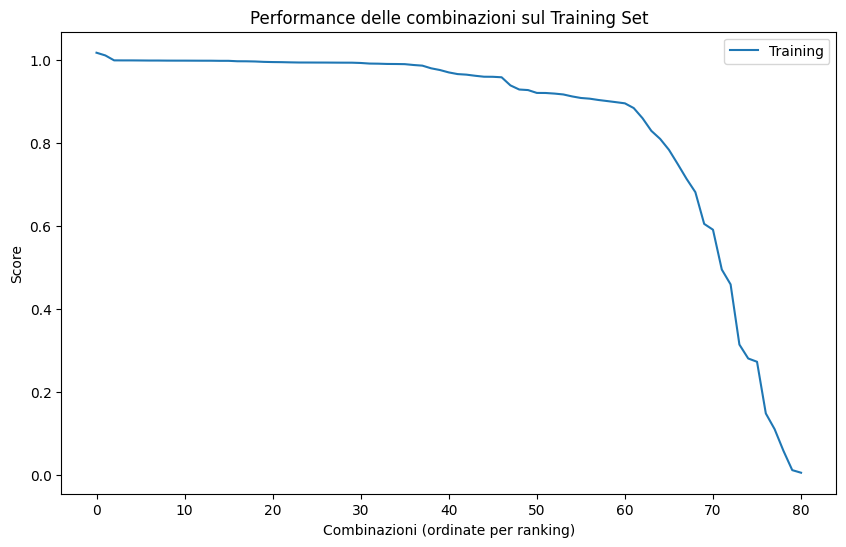

In [24]:
plt.figure(figsize=(10,6))
plt.plot(df_train_results['score'], label='Training')
plt.xlabel("Combinazioni (ordinate per ranking)")
plt.ylabel("Score")
plt.title("Performance delle combinazioni sul Training Set")
plt.legend()
plt.show()